In [1]:
import torch
from torch.autograd import Variable, grad
from pyro.distributions.torch.gamma import Gamma
from rejection_gamma import RejectionStandardGamma

import numpy as np
from matplotlib import pyplot
%matplotlib inline

In [2]:
alpha0 = 1.
alpha = Variable(alpha0 * torch.ones(1000), requires_grad=True)
beta = Variable(torch.ones(1000))
rgamma = RejectionStandardGamma(alpha)
gamma = Gamma(alpha, beta)

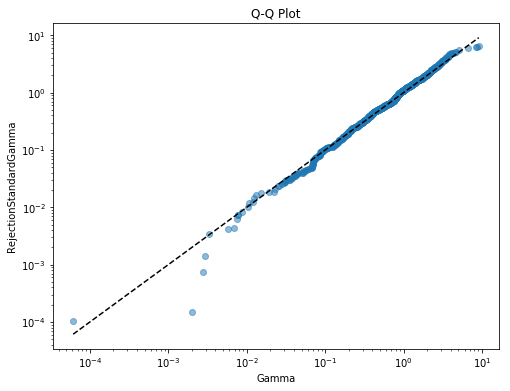

In [3]:
x = gamma.sample().data.numpy()
y = rgamma.sample().data.numpy()
x.sort()
y.sort()
min_max = [min(x[0], y[0]), max(x[-1], y[-1])]
pyplot.figure(figsize=(8,6)).patch.set_color('white')
pyplot.plot(min_max, min_max, 'k--')
pyplot.scatter(x, y, alpha=0.5)
pyplot.title('Q-Q Plot')
pyplot.xlabel('Gamma')
pyplot.ylabel('RejectionStandardGamma')
pyplot.xscale('log')
pyplot.yscale('log')
pyplot.show()

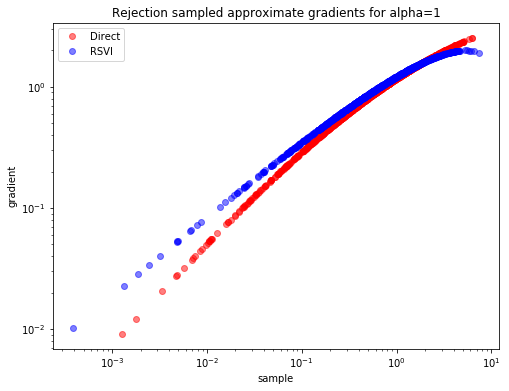

In [4]:
x = gamma.sample()
y = rgamma.sample() 
dx, = grad([x.sum()], [alpha], retain_graph=True)
dy, = grad([y.sum()], [alpha], retain_graph=True)

x, ind = x.data.sort(); dx = dx.data[ind]
y, ind = y.data.sort(); dy = dy.data[ind]

x = x.numpy(); dx = dx.numpy()
y = y.numpy(); dy = dy.numpy()
pyplot.figure(figsize=(8,6)).patch.set_color('white')
pyplot.plot(x, dx, 'ro', label='Direct', alpha=0.5)
pyplot.plot(y, dy, 'bo', label='RSVI', alpha=0.5)
pyplot.xlabel('sample')
pyplot.ylabel('gradient')
pyplot.xscale('log')
pyplot.yscale('log')
pyplot.title('Rejection sampled approximate gradients for alpha={:0.2g}'.format(alpha0))
pyplot.legend()
pyplot.show()

TODO add boosting and shape augmentation.